In [3]:
import pandas as pd
import json
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import os
os.chdir("/Users/Владислав/Data science")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Владислав\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Владислав\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_csv('lenta-ru-news.csv')

In [5]:
df.head()

,url,title,text,topic,tags
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество
1,https://lenta.ru/news/2018/12/15/doping/,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды
2,https://lenta.ru/news/2018/12/15/disneyland/,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Мир
3,https://lenta.ru/news/2018/12/15/usa25/,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,Политика
4,https://lenta.ru/news/2018/12/15/integrity/,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Общество


In [6]:
df.topic.value_counts()

Россия               160519
Мир                  136680
Экономика             79538
Спорт                 64421
Культура              53803
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44675
Из жизни              27611
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

In [7]:
df.drop(['url', 'tags'], axis = 1, inplace = True)
df.head()

,title,text,topic
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир


In [32]:
df = df[(df.topic != 'Оружие') & (df.topic != 'ЧМ-2014') & (df.topic != 'МедНовости') & (df.topic != 'Сочи') & \
        (df.topic != 'Библиотека') & (df.topic != 'Легпром') & (df.topic != 'Культпросвет ') & (df.topic != 'Крым') & (df.topic != '69-я параллель')].reset_index(drop=True)

In [33]:
df.topic.value_counts()

Россия               110679
Мир                   96626
Экономика             67255
Наука и техника       44511
Бывший СССР           42766
Спорт                 36118
Культура              36047
Интернет и СМИ        34655
Дом                   18357
Из жизни              17092
Силовые структуры     16275
Бизнес                 6948
Ценности               4877
Путешествия            4563
Name: topic, dtype: int64

In [34]:
df.duplicated(subset=['title','text']).sum()

107

In [35]:
print(len(df[df['title'] == ""]))

0


In [36]:
print(len(df[df['text'] == ""]))

0


In [37]:
print(len(df[df['topic'] == ""]))

0


In [38]:
df.drop_duplicates(subset=['title','text'],keep='last',inplace=True)

In [39]:
df.duplicated(subset=['title','text']).sum()

0

In [40]:
print(len(df[df['topic'] == np.nan]))

0


In [41]:
print(len(df[df['text'] == np.nan]))

0


In [42]:
print(len(df[df['title'] == np.nan]))

0


In [43]:
row_mask=df.isnull().any(axis=1)
col_mask=df.isnull().any(axis=0)
df.loc[row_mask,col_mask]

""


In [44]:
df = df.drop(index=df.loc[row_mask,col_mask].index)

In [45]:
row_mask=df.isnull().any(axis=1)
col_mask=df.isnull().any(axis=0)
df.loc[row_mask,col_mask]

""


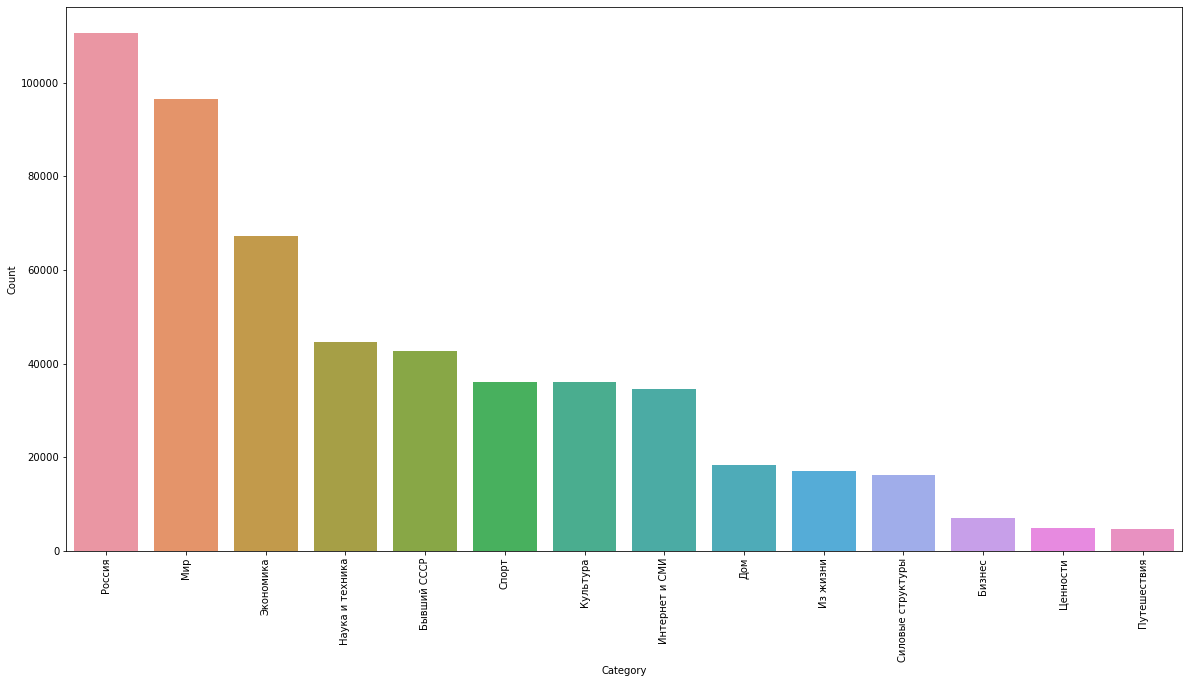

In [46]:
plt.figure(figsize=(20,10))
count = df.topic.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90);

In [47]:
df['title'].astype(str).apply(len).max()

132

In [48]:
df['title'].astype(str).apply(len).min()

13

In [49]:
df['text'].astype(str).apply(len).max()

4993

In [50]:
df['text'].astype(str).apply(len).min()

1001

In [51]:
df = df[(df['text'].astype(str).apply(len) < 5000) &  (df['text'].astype(str).apply(len) > 1000)].reset_index(drop=True)

In [52]:
df_mini = df[df.topic != 'Россия'].append(df[df.topic == 'Россия'].head(10000))

In [53]:
df_mini = df_mini[df_mini.topic != 'Мир'].append(df_mini[df_mini.topic == 'Мир'].head(10000))

In [54]:
df_mini = df_mini[df_mini.topic != 'Экономика'].append(df_mini[df_mini.topic == 'Экономика'].head(10000))

In [55]:
df_mini = df_mini[df_mini.topic != 'Спорт'].append(df_mini[df_mini.topic == 'Спорт'].head(10000))

In [56]:
df_mini = df_mini[df_mini.topic != 'Культура'].append(df_mini[df_mini.topic == 'Культура'].head(10000))

In [57]:
df_mini = df_mini[df_mini.topic != 'Бывший СССР'].append(df_mini[df_mini.topic == 'Бывший СССР'].head(10000))

In [58]:
df_mini = df_mini[df_mini.topic != 'Наука и техника'].append(df_mini[df_mini.topic == 'Наука и техника'].head(10000))

In [59]:
df_mini = df_mini[df_mini.topic != 'Интернет и СМИ'].append(df_mini[df_mini.topic == 'Интернет и СМИ'].head(10000))

In [60]:
df_mini = df_mini[df_mini.topic != 'Из жизни'].append(df_mini[df_mini.topic == 'Из жизни'].head(10000))

In [61]:
df_mini = df_mini[df_mini.topic != 'Дом'].append(df_mini[df_mini.topic == 'Дом'].head(10000))

In [62]:
df_mini = df_mini[df_mini.topic != 'Силовые структуры'].append(df_mini[df_mini.topic == 'Силовые структуры'].head(10000)).reset_index(drop=True)

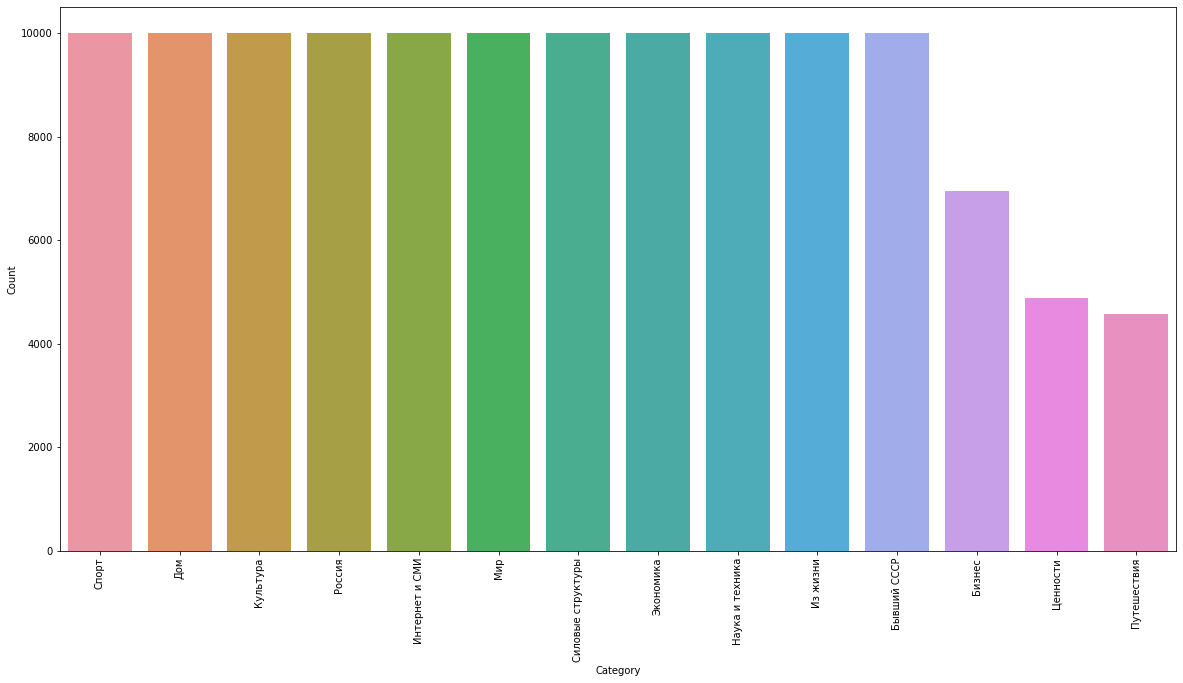

In [63]:
plt.figure(figsize=(20,10))
count = df_mini.topic.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90);

<AxesSubplot:>

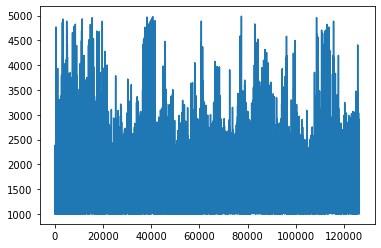

In [64]:
df_mini['text'].astype(str).apply(len).plot()

In [52]:
df_mini['Text_cleaning'] = df_mini['title'].astype(str) + ' '+ df_mini['text'].astype(str)

In [54]:
df_mini.drop(['title', 'text'], axis = 1, inplace = True)

In [64]:
pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()



  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=a6f394fecd070a498dce8969b76d338afbad74913c1d85da435053bf95341d16
  Stored in directory: c:\users\владислав\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [110]:
#sentence_example = df.iloc[113]['title']
sentence_example = 'введение платы за углеродные выбросы'
tokens = word_tokenize(sentence_example, language = 'russian')
token_with_out_punctuation = [i for i in tokens if (i not in string.punctuation) & (i != '—') & (i != '»') & (i != '«')]
russian_stopwords = stopwords.words('russian')
token_with_out_punctuation_and_stopwords = [i.lower() for i in token_with_out_punctuation if i not in russian_stopwords ]
lem_word = [ morph.parse(i)[0].normal_form for i in token_with_out_punctuation_and_stopwords]
snowball_stem = SnowballStemmer(language = 'russian')
stemmed_tokens = [snowball_stem.stem(i) for i in lem_word]

In [111]:
print(sentence_example)
print('---------------------------------------------')
print(tokens)
print('---------------------------------------------')
print(token_with_out_punctuation)
print('---------------------------------------------')
print(token_with_out_punctuation_and_stopwords)
print('---------------------------------------------')
print(lem_word)
print('---------------------------------------------')
print(stemmed_tokens)

введение платы за углеродные выбросы
---------------------------------------------
['введение', 'платы', 'за', 'углеродные', 'выбросы']
---------------------------------------------
['введение', 'платы', 'за', 'углеродные', 'выбросы']
---------------------------------------------
['введение', 'платы', 'углеродные', 'выбросы']
---------------------------------------------
['введение', 'плата', 'углеродный', 'выброс']
---------------------------------------------
['введен', 'плат', 'углеродн', 'выброс']


In [74]:
def clean_text(text):
    tokens = word_tokenize(text.lower(), language = 'russian')
    token_with_out_punctuation = [i for i in tokens if (i not in string.punctuation) & (i != '—') & (i != '«') & (i != '»')]
    russian_stopwords = stopwords.words('russian')
    token_with_out_punctuation_and_stopwords = [i for i in token_with_out_punctuation if i not in russian_stopwords ]
    token_with_out_punctuation_and_stopwords_and_lemming = [ morph.parse(i)[0].normal_form for i in token_with_out_punctuation_and_stopwords]
    snowball_stem = SnowballStemmer(language = 'russian')
    text = " ".join([snowball_stem.stem(i) for i in token_with_out_punctuation_and_stopwords_and_lemming])
    return text

In [50]:
df_mini['Text_cleaning'] = df_mini.Text_cleaning.apply(clean_text)
df_mini

,topic,Text_cleaning
0,Ценности,седин станет модн американск интернет-сервис p...
1,Путешествия,египтян организова турист секс пирамид поплат ...
2,Ценности,хваста дорог вещ батюшк раскр источник сво бог...
3,Путешествия,индиец попристава модел самолет сел девя лет п...
4,Ценности,раскрыт реальн внешност модел victoria ’ s sec...
...,...,...
127691,Силовые структуры,заверш следств дел генера мвд сугробов заверш ...
127692,Силовые структуры,задержа подозрева убийств эпизодник гардемарин...
127693,Силовые структуры,крест умер предполага насильник гантел следств...
127694,Силовые структуры,суд арестова активист барабаш дел журналист рб...


In [55]:
df_mini.to_csv('df_for_model.csv')

In [2]:
df_for_model = pd.read_csv('df_for_model.csv', index_col=0)

In [3]:
df_for_model

,topic,Text_cleaning
0,Ценности,седин станет модн американск интернет-сервис p...
1,Путешествия,египтян организова турист секс пирамид поплат ...
2,Ценности,хваста дорог вещ батюшк раскр источник сво бог...
3,Путешествия,индиец попристава модел самолет сел девя лет п...
4,Ценности,раскрыт реальн внешност модел victoria ’ s sec...
...,...,...
127691,Силовые структуры,заверш следств дел генера мвд сугробов заверш ...
127692,Силовые структуры,задержа подозрева убийств эпизодник гардемарин...
127693,Силовые структуры,крест умер предполага насильник гантел следств...
127694,Силовые структуры,суд арестова активист барабаш дел журналист рб...


In [5]:
df_for_model.topic.value_counts()

Экономика            10000
Наука и техника      10000
Силовые структуры    10000
Мир                  10000
Бывший СССР          10000
Дом                  10000
Россия               10000
Культура             10000
Интернет и СМИ       10000
Спорт                10000
Из жизни             10000
Бизнес                6948
Ценности              4877
Путешествия           4563
Name: topic, dtype: int64

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [7]:
X_train, X_test, y_train, y_test = \
train_test_split(df_for_model['Text_cleaning'], df_for_model['topic'], test_size=0.2, random_state=42)

In [11]:
from sklearn.feature_extraction.text import  TfidfVectorizer

sgd_ppl_clf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=42))])
knb_ppl_clf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', KNeighborsClassifier())])

In [12]:
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', SGDClassifier(random_state=42))])

In [13]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                   precision    recall  f1-score   support

           Бизнес       0.72      0.78      0.75      1292
      Бывший СССР       0.92      0.85      0.89      2128
              Дом       0.93      0.89      0.91      2042
         Из жизни       0.77      0.82      0.79      1901
   Интернет и СМИ       0.79      0.82      0.81      2008
         Культура       0.94      0.85      0.89      2272
              Мир       0.84      0.80      0.82      2106
  Наука и техника       0.90      0.89      0.89      1937
      Путешествия       0.86      0.82      0.84       946
           Россия       0.65      0.84      0.74      1501
Силовые структуры       0.86      0.78      0.82      2143
            Спорт       0.98      0.92      0.95      2090
         Ценности       0.87      0.89      0.88      1002
        Экономика       0.79      0.85      0.82      1910

         accuracy                           0.84     25278
        macro avg       0.84      0.84      0.84     2

In [16]:
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', KNeighborsClassifier())])

In [17]:
predicted_knb = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_knb, y_test))

                   precision    recall  f1-score   support

           Бизнес       0.74      0.65      0.69      1586
      Бывший СССР       0.89      0.79      0.84      2197
              Дом       0.87      0.81      0.84      2122
         Из жизни       0.65      0.68      0.66      1945
   Интернет и СМИ       0.63      0.77      0.69      1691
         Культура       0.82      0.81      0.81      2114
              Мир       0.79      0.73      0.76      2204
  Наука и техника       0.83      0.84      0.83      1884
      Путешествия       0.74      0.79      0.77       851
           Россия       0.63      0.71      0.66      1713
Силовые структуры       0.76      0.76      0.76      1962
            Спорт       0.95      0.92      0.93      2046
         Ценности       0.80      0.88      0.84       931
        Экономика       0.79      0.80      0.80      2032

         accuracy                           0.78     25278
        macro avg       0.78      0.78      0.78     2

In [20]:
from sklearn.ensemble import RandomForestClassifier
rndf_ppl_clf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', RandomForestClassifier())])


In [21]:
rndf_ppl_clf.fit(X_train, y_train)
predicted_rndf = rndf_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_rndf, y_test))

                   precision    recall  f1-score   support

           Бизнес       0.66      0.77      0.71      1195
      Бывший СССР       0.87      0.81      0.84      2123
              Дом       0.89      0.87      0.88      2006
         Из жизни       0.76      0.70      0.73      2191
   Интернет и СМИ       0.69      0.77      0.72      1854
         Культура       0.87      0.83      0.85      2171
              Мир       0.78      0.75      0.76      2097
  Наука и техника       0.86      0.88      0.87      1887
      Путешествия       0.73      0.83      0.78       796
           Россия       0.59      0.78      0.67      1458
Силовые структуры       0.83      0.72      0.77      2273
            Спорт       0.98      0.90      0.93      2155
         Ценности       0.82      0.93      0.87       905
        Экономика       0.82      0.78      0.80      2167

         accuracy                           0.80     25278
        macro avg       0.80      0.81      0.80     2

In [ ]:
parameters = { 
              'model__loss':['hinge', 'log', 'modified_huber', 'perceptron'],
              'model__class_weight':[None, 'balanced'],
              'model__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'vectorizer__strip_accents':['ascii', 'unicode'],
              'vectorizer__ngram_range':[(1,2), (3,4)]
              }
#model = GridSearchCV(sgd_ppl_clf_1, parameters,cv=4, n_jobs=-1).fit(X_train_1, y_train_1)
#search = RandomizedSearchCV(sgd_ppl_clf_1, 
#param_distributions=parameters, n_iter=50)
#search.fit(X_train_1, y_train_1)


print("Подборка началась...") 
search = RandomizedSearchCV(sgd_ppl_clf, param_distributions=parameters, verbose=8, error_score='raise') 
search.fit(X_train, y_train) 


Подборка началась...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__class_weight=balanced, model__loss=log, model__penalty=l1, vectorizer__ngram_range=(3, 4), vectorizer__strip_accents=ascii; total time=  31.5s
[CV 2/5] END model__class_weight=balanced, model__loss=log, model__penalty=l1, vectorizer__ngram_range=(3, 4), vectorizer__strip_accents=ascii; total time=  31.5s
[CV 3/5] END model__class_weight=balanced, model__loss=log, model__penalty=l1, vectorizer__ngram_range=(3, 4), vectorizer__strip_accents=ascii; total time=  31.3s
[CV 4/5] END model__class_weight=balanced, model__loss=log, model__penalty=l1, vectorizer__ngram_range=(3, 4), vectorizer__strip_accents=ascii; total time=  31.4s
[CV 5/5] END model__class_weight=balanced, model__loss=log, model__penalty=l1, vectorizer__ngram_range=(3, 4), vectorizer__strip_accents=ascii; total time=  31.4s
[CV 1/5] END model__class_weight=balanced, model__loss=perceptron, model__penalty=elasticnet, vectorize

In [ ]:
search.best_params_

In [19]:
sgd_ppl_clf_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2), strip_accents = 'unicode')),
    ('model', SGDClassifier(penalty='l2', class_weight=None, loss='perceptron', random_state=42))])
sgd_ppl_clf_1.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf_1.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                   precision    recall  f1-score   support

           Бизнес       0.80      0.82      0.81      1355
      Бывший СССР       0.93      0.90      0.91      2022
              Дом       0.94      0.93      0.94      1980
         Из жизни       0.82      0.85      0.84      1957
   Интернет и СМИ       0.81      0.87      0.84      1940
         Культура       0.90      0.91      0.91      2052
              Мир       0.87      0.84      0.86      2088
  Наука и техника       0.92      0.92      0.92      1919
      Путешествия       0.89      0.85      0.87       952
           Россия       0.82      0.80      0.81      1986
Силовые структуры       0.88      0.84      0.86      2038
            Спорт       0.97      0.95      0.96      2017
         Ценности       0.93      0.91      0.92      1041
        Экономика       0.84      0.89      0.87      1931

         accuracy                           0.88     25278
        macro avg       0.88      0.88      0.88     2